# Convolutional Cubic Splines

$C^2$-continuous cubic splines through evenly spaced data points can be created by convolving the data points with a $C^2$-continuous piecewise cubic kernel, characterized as follows:

\begin{split}
 y(0) &= 1\\
 y(x) &= 0,\text{ for all integer }x \neq 0\\
 y'(x) &= sgn(x) * 3(\sqrt3-2)^{|x|},\text{ for all integer }x\\
\end{split}
which implies

 $$y''(x) = -6\sqrt 3(\sqrt3-2)^{|x|},\text{ for all integer }x \neq 0$$

The double-sided exponential allows the convolution to be performed extremely efficiently.

Any of the standard boundary conditions can then be applied by adjusting the start and end derivatives appropritately, and propagating the change to the rest of the curve.

The following function calculates "natural" cubic splines (with $y'' = 0$ at start and end) using this technique, which is much easiser than the way everyone is taught!

Use it however you like.

Cheers,

Matt Timmermans

In [27]:
import math
#given an array of Y values at consecutive integral x abscissas,
#return array of corresponding derivatives to make a natural cubic spline
def naturalSpline(ys):
    vs = [0.0] * len(ys)
    if (len(ys) < 2):
        return vs
    
    DECAY = math.sqrt(3)-2;
    endi = len(ys)-1

    # make convolutional spline
    S = 0.0;E = 0.0
    for i in range(len(Y)):
        vs[i]+=S;vs[endi-i]+=E;
        S=(S+3.0*ys[i])*DECAY;
        E=(E-3.0*ys[endi-i])*DECAY;

    #Natural Boundaries
    S2 = 6.0*(ys[1]-ys[0]) - 4.0*vs[0] - 2.0*vs[1]
    E2 = 6.0*(ys[endi-1]-ys[endi]) + 4.0*vs[endi] + 2.0*vs[endi-1]
    # A = dE2/dE = -dS2/dS,  B = dE2/dS = -dS2/dS
    A = 4.0+2.0*DECAY
    B = (4.0*DECAY+2.0)*(DECAY**(len(ys)-2))
    DEN = A*A - B*B
    S = (A*S2 + B*E2) / DEN
    E = (-A*E2 - B*S2) / DEN
    for i in range(len(ys)):
        vs[i]+=S;vs[endi-i]+=E
        S*=DECAY;E*=DECAY
    return vs

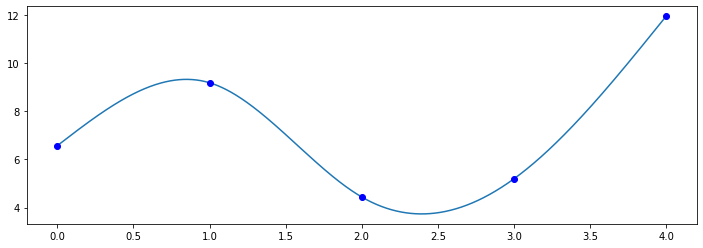

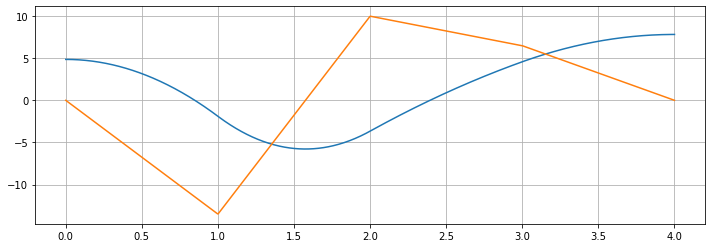

In [28]:
#
#Plot a different natural spline, along with its 1st and 2nd derivatives, each time you run this
#
%run plothelp.py
%matplotlib inline
import random
import numpy
Y = [random.random()*10.0+2 for _ in range(5)]
V = naturalSpline(Y)
xs = numpy.linspace(0,len(Y)-1, 1000)
plt.figure(0, figsize=(12.0,4.0))
plt.plot(xs,[hermite_interp(Y,V,x) for x in xs])
plt.plot(range(0,len(Y)),[Y[x] for x in range(0,len(Y))], "bo")
plt.figure(1, figsize=(12.0,4.0));plt.grid(True)
plt.plot(xs,[hermite_interp1(Y,V,x) for x in xs])
plt.plot(xs,[hermite_interp2(Y,V,x) for x in xs])

## The Kernel

The kernel decays quickly around $x=0$, which is why cubic splines suffer from very little "ringing" -- moving one point doesn't significantly affect the curve at points far away.

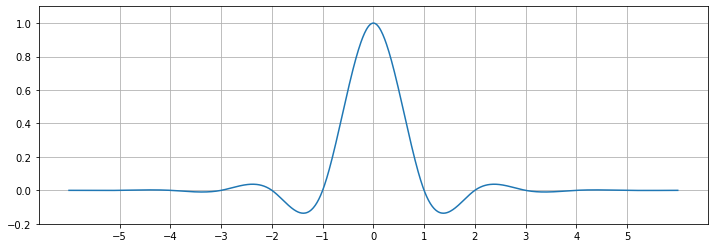

In [29]:
#
# Plot the kernel
#
DECAY = math.sqrt(3)-2;
vs = [3*(DECAY**x) for x in range(1,7)]
ys = [0]*len(vs) + [1] + [0]*len(vs)
vs = [-v for v in vs[::-1]] + [0.0] + vs
xs = numpy.linspace(0,len(ys)-1, 1000)
plt.figure(0, figsize=(12.0,4.0));plt.grid(True);plt.ylim([-0.2,1.1]);plt.xticks(range(-5,6))
plt.plot([x-6.0 for x in xs],[hermite_interp(ys,vs,x) for x in xs])

## Derivation

Each segment of the curve is a cubic polynomial, which has 4 unknowns: $Y = Ax^3 + Bx^2 + C +D$.

The kernel consists of two *main lobe* segments (for $\text{x in }[-1,0]$ and $\text{x in }[0,1]$), and many *side lobe* segments.

For each side lobe, the end points are set:

$$
\begin{split}
 y_0 &= 0\\
 y_1 &= 0
\end{split}
$$

There are only 2 unknowns left, so specifying the first and second derivatives at one end will fix the first and second derivatives at the other end as well.  There is a linear relationship:

$$
\begin{bmatrix}
    y'_1 \\
    y''_1
\end{bmatrix}
=
\begin{bmatrix}
    -2 & -\frac{1}{2} \\
    -6 & -2
\end{bmatrix}
\begin{bmatrix}
    y'_0 \\
    y''_0
\end{bmatrix}
$$

If $(y'_0,y''_0)$ is an eigenvector of this matrix, then $(y'_1,y''_1)$ will be as well, implying the same for $(y'_2,y''_2)$, etc.  All of the adjacent sidelobes will have the same shape with different amplitudes.

The two eigenvectors correspond to exponentially increasing or decreasing sidelobe amplitudes, respectively:

$$
\begin{split}
\begin{bmatrix}
    -2 & -\frac{1}{2} \\
    -6 & -2
\end{bmatrix}
\begin{bmatrix}
    1 \\
    2\sqrt{3}
\end{bmatrix}
&=
\frac{1}{\sqrt{3}-2}
\begin{bmatrix}
    1 \\
    2\sqrt{3}
\end{bmatrix}
\\
\begin{bmatrix}
    -2 & -\frac{1}{2} \\
    -6 & -2
\end{bmatrix}
\begin{bmatrix}
    1 \\
    -2\sqrt{3}
\end{bmatrix}
&=
\left(\sqrt{3}-2\right)
\begin{bmatrix}
    1 \\
    -2\sqrt{3}
\end{bmatrix}
\end{split}
$$

To create the kernel, then, we just calculate the main lobes to meet the side lobes with first and second derivaties along these eigenvectors.  The $C^2$-continuity requirement then forces exponentially decaying sidelobes on both sides:

$$
\begin{gather}
y(0)=1\\
y'(0) = 0
\\
y(-1) = y(1) = 0
\\
\frac{y''(-1)}{y'(-1)} = -\frac{y''(1)}{y'(1)} = 2\sqrt{3}
\end{gather}
$$